In [2]:
#this is probably useless
from PIL import Image
import numpy as np
def find_rgb(filepath, r_threshold, g_threshold, b_threshold):
    img = Image.open(filepath)
    pix = img.load()
    coordinates= []
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            r, g, b = pix[x,y]
            if match(r, g, b, r_threshold, g_threshold, b_threshold):
                coordinates.append((x, y))
    return(coordinates)


def match(r, g, b, r_query, g_query, b_query):
    if r >= r_query and g >= g_query and b>=b_query:
        return True
    else:
        return False

In [6]:
#create binary image
#we may not need this eventually
from PIL import Image
import numpy as np

img = Image.open('handImage_1.png')
img_width = img.size[0]
img_height = img.size[1]
bin_img = np.zeros((img_width, img_height))
thresh_1 = 135
thresh_2 = 96
pix = img.load()
for x in range(img_width):
    for y in range(img_height):
        r,g,b = pix[x,y]
        if r > thresh_2 and r < thresh_1:
            bin_img[x,y] = 1   #change to 127 if RGB needed
     

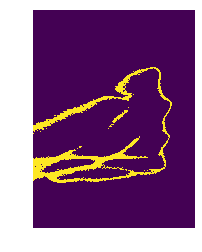

In [7]:
#save separate binary pic if needed

import numpy as np
from matplotlib import pyplot as plt
image = bin_img
binary = image > 0
plt.imshow(binary)
plt.axis('off')
plt.savefig('plsgod.png')
plt.show()

In [23]:
import cv2
# Otsu's thresholding after Gaussian filtering
img = cv2.imread('handImage_1.png',0)
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#print(th3)
cv2.imshow('image',th3)




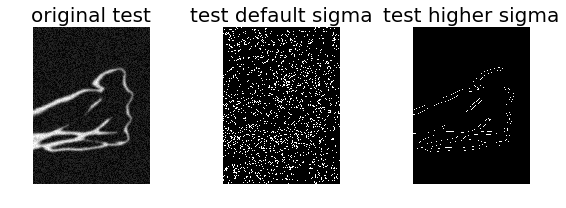

In [8]:
#edge detection

import numpy as np
import skimage
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature

#filename = 'handImage_1.png'
#image = skimage.io.imread(fname = filename, as_gray = True)
image = bin_img

#########INDIVIUDAL PIC##########
#f, ax = plt.subplots()
#ax.imshow(image,cmap = plt.cm.gray)
#ax.axis('off')
#plt.savefig('testBinary2.png',dpi = 300)
#plt.show()

#image = ndi.rotate(image, 15, mode='constant')
image = ndi.gaussian_filter(image, 4)
image += 0.2 * np.random.random(image.shape)

#canny filter
edges1 = feature.canny(image, sigma = 1)
edges2 = feature.canny(image,sigma = 5, low_threshold = 0.1, high_threshold = 0.1)

#display
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (8,3), sharex = True, sharey = True)
ax1.imshow(image,cmap = plt.cm.gray)
ax1.axis('off')
ax1.set_title('original test', fontsize = 20)

ax2.imshow(edges1, cmap = plt.cm.gray)
ax2.axis('off')
ax2.set_title('test default sigma', fontsize = 20)

ax3.imshow(edges2,cmap = plt.cm.gray)
ax3.axis('off')
ax3.set_title('test higher sigma', fontsize = 20)

fig.tight_layout()

plt.savefig('testVeins.png', dpi = 300)
plt.show()


In [107]:
#minimum area, measurements from rectangle
import cv2
import numpy as np
from PIL import Image, ImageDraw

img = cv2.imread('testBinary2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((3,3), dtype=np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the index of the smallest contour
areas = [cv2.contourArea(c) for c in contours]
min_index = np.argmin(areas)
cnt=contours[min_index]

x,y,w,h = cv2.boundingRect(cnt)
cv2.rectangle(img, (x,y), (x+w, y+h), (255,255,0), 1)

#img = cv2.putText(img,' "width:{:.1f}".format(w)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,
    #0.65, (255, 255, 255), 2)
#img = cv2.putText(img,' "height:{:.1f}".format(h)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,
    #0.65, (255, 255, 255), 2)
cv2.putText(img,"height:{:.1f}".format(h),(800,200),cv2.FONT_HERSHEY_SIMPLEX,0.65,255)
cv2.putText(img,"width:{:.1f}".format(w),(800,250),cv2.FONT_HERSHEY_SIMPLEX,0.65,255)

cv2.imwrite('testMeasure.png',img)
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [76]:
#######DOESNT WORK######
#need to fix image size conversion
#this could be useful for multiple veins

# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# load the image, convert it to grayscale, and blur it slightly
#image = cv2.imread('TestImage2.png')
image = cv2.imread('testBinary2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
    # compute the rotated bounding box of the contour
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
        
# unpack the ordered bounding box, then compute the midpoint
# between the top-left and top-right coordinates, followed by
# the midpoint between bottom-left and bottom-right coordinates
(tl, tr, br, bl) = box
(tltrX, tltrY) = midpoint(tl, tr)
(blbrX, blbrY) = midpoint(bl, br)
# compute the midpoint between the top-left and top-right points,
# followed by the midpoint between the top-righ and bottom-right
(tlblX, tlblY) = midpoint(tl, bl)
(trbrX, trbrY) = midpoint(tr, br)
# draw the midpoints on the image
cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
# draw lines between the midpoints
cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
    (255, 0, 255), 2)
cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
    (255, 0, 255), 2)

    # compute the Euclidean distance between the midpoints
dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
# if the pixels per metric has not been initialized, then
# compute it as the ratio of pixels to supplied metric
# (in this case, inches)
if pixelsPerMetric is None:
    pixelsPerMetric = 1

# compute the size of the object
dimA = dA / pixelsPerMetric
dimB = dB / pixelsPerMetric
# draw the object sizes on the image
cv2.putText(orig, "{:.1f}in".format(dimA),
    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (255, 255, 255), 2)
cv2.putText(orig, "{:.1f}in".format(dimB),
    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (255, 255, 255), 2)
# show the output image
cv2.imshow("Image", orig)
cv2.waitKey(0)

print(dimA)


216.0


In [75]:
####DOESN'T WORK#########
#this should be an easier version of the cell above. but edges are not continuous

#Finding the contours in the image
img = cv2.imread('testBinary2.png')
#im2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

binary = cv2.threshold(gray,255,255,cv2.THRESH_BINARY_INV)

contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
image = cv2.drawContours(img,contours,-1,(0,255,0),2)
#finding the minimum area rectangle that covers the blob
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img,[box],0,(0,0,255),2)

#Forming the line vector
v = np.matrix([[0], [1]])

#forming the rotation matrix to rotate the line vector
ang = rect[2]* np.pi / 180 #conversion to radians
rot = np.matrix([[np.cos(ang), -np.sin(ang)],[np.sin(ang), np.cos(ang)]])

#Rotating the horizontal vector
rv = rot*v

#half length of the line
lineSize = max(rect[1])*0.5

#extreme points of the line
p1 = tuple(np.array(rect[0] - lineSize*rv.T)[0].astype(int))
p2 = tuple(np.array(rect[0] + lineSize*rv.T)[0].astype(int))

cv2.line(img, p1, p2, (0,255,0), 2)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
